In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import pdist

from scipy.spatial.distance import squareform
from scipy.spatial.distance import pdist, jaccard
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
from matplotlib.patches import Rectangle


BASE_PATH = "/".join(os.getcwd().split("/")) # base dire"ctory level

DATA_PATH = os.path.join(BASE_PATH, "../../../dowloads/")  # where I dump new data
COMP_PATH = os.path.join(DATA_PATH,"1KGvs1KG")

In [70]:
def get_window_dendrogram(w, idx):
    fig, ax = plt.subplots(1, figsize=(20,3))
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    sch.set_link_color_palette(['darkgrey', 'grey','black'])
    dg = sch.dendrogram(tree_complete[w][0], show_leaf_counts=True, labels=idx, leaf_font_size=10)
    plt.xticks([])
    plt.xlim(left = -10)
    plt.ylim(bottom = -.001)
    plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)


    leaf_x = [(x * 10)+5 for x in dg['leaves']]
    leaf_y = [0] * 131

    sup_pal = {'AFR':'#f77189', 'SAS':'#36ada4','EAS':'#50b231','AMR':'#3ba3ec','EUR':'#bb9832', 'anc':'grey'}

    lineage_dict = {}
    for i in range(len(idx)):
        lineage_dict[i]=idx[i]
        
    colors = {}
    for k in lineage_dict.keys():
        i = k*10 + 5
        c = lineage_dict[k]
        if c != 'anc':
            c = c[:3]
        c = sup_pal[c]
        colors[i] = c

    new_colors = [colors[i] for i in leaf_x]

    # create new x for plotting leaves
    new_leaf_x = range(5,1315,10)
    plt.scatter(new_leaf_x, leaf_y, c = new_colors, zorder = 10)
    
    plt.xlabel('\nIndividuals', size = 14) # label of the x-axis
    plt.ylabel('Divergence\n', size = 14) # label of the y-axis
    plt.title(str(w))
    plt.show()
    return dg


def one_window_tree(dict3d, w, tree_summary, tree_complete, link_method, idx):
        window_df = dict_3d[w].loc[idx][idx]
        length = len(idx)
        array = window_df.reindex(index=idx, columns=idx).fillna(0, downcast='infer').to_numpy()
        condensed = array[np.triu_indices(length, k = 1)]
        Z = sch.linkage(condensed, method = link_method)
        dendrogram = sch.dendrogram(Z, labels=idx)
        whole_tree = [Z, dendrogram]

        cluster_sample_IDs = dendrogram['leaves']
        cluster_IDs = dendrogram['leaves_color_list']
        clusters_dict = dict(zip(cluster_sample_IDs, cluster_IDs))

        cluster_IDs_list = []
        for key, value in sorted(clusters_dict.items()):
                cluster_IDs_list.append(value)

        top_tree_y = dendrogram['dcoord'][-1]
        window_stats = cluster_IDs_list + top_tree_y


        return window_stats, whole_tree

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
comp_list = pd.read_csv('%s/comp_tables/pairwise_subsample_genomewide_averages.csv' % DATA_PATH,
                       index_col=0)
windows = pd.read_table('%s/intermediates/windows_to_keep.csv' % DATA_PATH, sep=',', index_col=[1,2]).drop(columns=['Unnamed: 0'])

dict_seq = pickle.load( open( "%s/dict_seq.p" % DATA_PATH, "rb" ) )
matrix_seq = pickle.load( open( "%s/matrix_seq.p" % DATA_PATH, "rb" ) )

dict_3d = pickle.load( open( "%s/dict_3d.p" % DATA_PATH, "rb" ) )
matrix_3d = pickle.load( open( "%s/matrix_3d.p" % DATA_PATH, "rb" ) )


windows_tuples = list(dict_3d.keys())


In [5]:
idx_wa = sorted(set(comp_list.ind1).union(comp_list.ind2))
idx = idx_wa + ['anc']

In [6]:

anc_spear = pd.read_table('%s/comp_tables/anc_window_spearman.csv' % DATA_PATH
                    , sep=',', header=[0,1,2,3], index_col=[0,1])
anc_div = 1-anc_spear
anc_div.columns = ['_'.join(col) for col in anc_div.columns.values]
anc_div = anc_div[idx_wa]


In [7]:
for w in dict_3d.keys():
    b = anc_div.loc[[w]]
    b = b.reset_index(drop=True).rename(index={0:'anc'})
    a = dict_3d[w].copy()
    a = a[idx_wa].loc[idx_wa].append(b)
    a['anc'] = b.T['anc']

    dict_3d[w] = a

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800


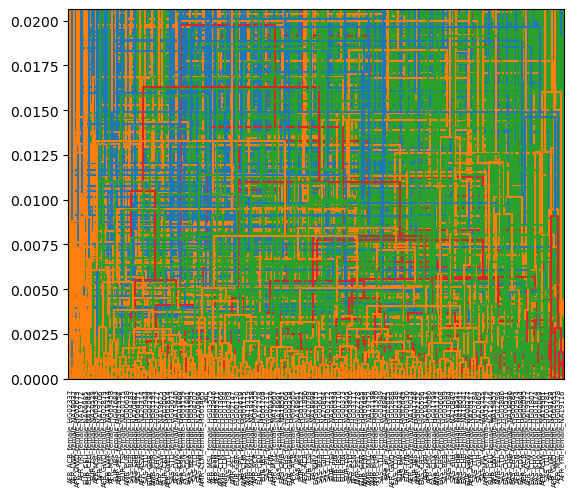

In [8]:
tree_summary = {}
tree_complete = {}
#takes about 3 minutes 20 seconds +/-
for i in range(len(windows_tuples)):
    w = windows_tuples[i]
    window_stats, whole_tree = one_window_tree(dict_3d, w, tree_summary, tree_complete, link_method='complete', idx=idx)
    tree_summary[w] = window_stats
    tree_complete[w] = whole_tree

    if i%100==0:
        print(i)

In [11]:
dataframe = pd.DataFrame.from_dict(tree_summary, orient='index', columns=list(idx) + ['coord_0','coord_1','coord_2','coord_3'])

counts_df = dataframe.drop(columns=['coord_0','coord_1', 'coord_2','coord_3']).apply(lambda s: s.value_counts(), axis=1).fillna(0)     
counts_df['depth'] = dataframe['coord_1']


In [13]:
idw = counts_df[(counts_df.C0==1 )|(counts_df.C1==1)|(counts_df.C2==1)|(counts_df.C3==1)|(counts_df.C4==1)|(counts_df.C5==1)]

In [14]:
idw_list = []
for r in idw.index:
    row = dataframe.loc[[r]]
    ind = row.where(row=='C0').dropna(how='all').dropna(axis=1).dropna(axis=1).columns[0]
    idw_list.append(ind)

In [15]:
len(idw_list)

1272

In [17]:
idw['individual'] = idw_list

In [18]:
idw.individual.value_counts().head(n=50)

anc                       65
AFR_LWK_female_NA19446    24
AFR_ASW_female_NA19917    22
AFR_ACB_female_HG01896    22
AFR_MSL_female_HG03378    21
AFR_ASW_female_NA19901    21
AFR_MSL_female_HG03086    20
AFR_GWD_female_HG02679    20
AFR_LWK_female_NA19314    20
AFR_GWD_female_HG02635    19
AFR_ACB_female_HG02555    19
AFR_ESN_female_HG02974    18
AFR_LWK_female_NA19037    18
AFR_ESN_female_HG03111    18
AFR_MSL_female_HG03458    18
AFR_YRI_female_NA19172    17
AFR_LWK_female_NA19457    17
AFR_MSL_female_HG03575    17
AFR_GWD_female_HG02888    17
SAS_ITU_female_HG03772    17
AFR_MSL_female_HG03583    17
AFR_LWK_female_NA19024    16
AFR_YRI_female_NA19116    16
AFR_ESN_female_HG03159    15
SAS_STU_female_HG03673    15
SAS_PJL_female_HG02655    14
EAS_KHV_female_HG01874    14
EAS_KHV_female_HG02069    14
EAS_KHV_female_HG01869    13
AMR_PUR_female_HG01191    13
AFR_GWD_female_HG02879    13
SAS_BEB_female_HG03611    13
AMR_PUR_female_HG01326    13
AFR_GWD_female_HG02814    12
SAS_STU_female

(array([539., 291., 142.,  77.,  41.,  30.,  33.,  25.,  18.,  16.,  15.,
          3.,   4.,   5.,   2.,   4.,   4.,   0.,   2.,   1.,   1.,   0.,
          0.,   0.,   7.,   6.,   0.,   0.,   2.,   0.,   0.,   0.,   1.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([2.32425767e-04, 1.28875252e-02, 2.55426246e-02, 3.81977241e-02,
        5.08528235e-02, 6.35079229e-02, 7.61630223e-02, 8.88181218e-02,
        1.01473221e-01, 1.14128321e-01, 1.26783420e-01, 1.39438519e-01,
        1.52093619e-01, 1.64748718e-01, 1.77403818e-01, 1.90058917e-01,
        2.02714017e-01, 2.15369116e-01, 2.28024215e-01, 2.40679315e-01,
        2.53334414e-01, 2.65989514e-01, 2.78644613e-01, 2.91299713e-01,
        3.03954812e-01, 3.16609912e-01, 3.29265011e-01, 3.41920110e-01,
        3.54575210e-01, 3.67230309e-01, 3.79885409e-01, 3.92540508e-01,
        4.05195608e-01, 4.17850707e-01, 4.30505806e-01, 4.43160906e-01,
        4.

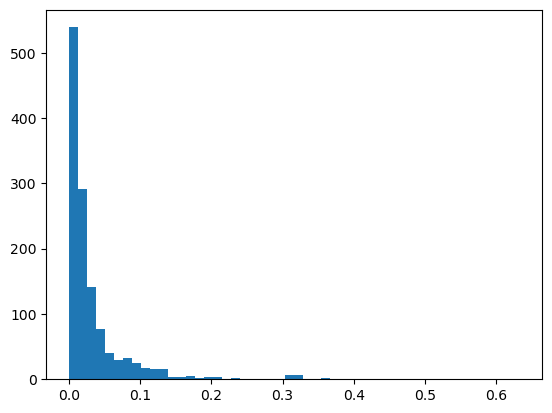

In [19]:
plt.hist(idw.depth, bins=50)

In [20]:
def get_super_pop(idw_row):
    return idw_row.individual.split('_')[0]
    

In [23]:
idw_counts = dict.fromkeys(['AFR','AMR','EUR','EAS','SAS','anc'])
for key in idw_counts.keys():
    idw_counts[key] = 0

for i in range(idw.shape[0]):
    super_pop = get_super_pop(idw.iloc[i])
    idw_counts[super_pop] += 1

In [36]:
idw[idw.individual=='anc']

,C0,C1,C2,C3,C4,C5,depth,individual
"(chr1, 67108864)",1.0,6.0,124.0,0.0,0.0,0.0,0.003538,anc
"(chr1, 168820736)",1.0,29.0,101.0,0.0,0.0,0.0,0.015923,anc
"(chr1, 169345024)",1.0,101.0,29.0,0.0,0.0,0.0,0.015162,anc
"(chr1, 192937984)",1.0,39.0,91.0,0.0,0.0,0.0,0.027680,anc
"(chr2, 108003328)",1.0,130.0,0.0,0.0,0.0,0.0,0.016311,anc
...,...,...,...,...,...,...,...,...
"(chr17, 65011712)",1.0,90.0,2.0,38.0,0.0,0.0,0.003880,anc
"(chr17, 80216064)",1.0,30.0,100.0,0.0,0.0,0.0,0.008849,anc
"(chr19, 9961472)",1.0,130.0,0.0,0.0,0.0,0.0,0.017462,anc
"(chr19, 30932992)",1.0,130.0,0.0,0.0,0.0,0.0,0.104280,anc


In [54]:
w

('chr22', 48758784)

In [61]:
sup_pal

{'AFR': '#f77189',
 'SAS': '#36ada4',
 'EAS': '#50b231',
 'AMR': '#3ba3ec',
 'EUR': '#bb9832',
 'anc': 'grey'}

In [62]:
lineage_dict

{0: 'AFR_ACB_female_HG01896',
 1: 'AFR_ACB_female_HG02095',
 2: 'AFR_ACB_female_HG02337',
 3: 'AFR_ACB_female_HG02505',
 4: 'AFR_ACB_female_HG02555',
 5: 'AFR_ASW_female_NA19625',
 6: 'AFR_ASW_female_NA19901',
 7: 'AFR_ASW_female_NA19917',
 8: 'AFR_ASW_female_NA20314',
 9: 'AFR_ASW_female_NA20317',
 10: 'AFR_ESN_female_HG02946',
 11: 'AFR_ESN_female_HG02974',
 12: 'AFR_ESN_female_HG03111',
 13: 'AFR_ESN_female_HG03159',
 14: 'AFR_ESN_female_HG03511',
 15: 'AFR_GWD_female_HG02635',
 16: 'AFR_GWD_female_HG02679',
 17: 'AFR_GWD_female_HG02814',
 18: 'AFR_GWD_female_HG02879',
 19: 'AFR_GWD_female_HG02888',
 20: 'AFR_LWK_female_NA19024',
 21: 'AFR_LWK_female_NA19037',
 22: 'AFR_LWK_female_NA19314',
 23: 'AFR_LWK_female_NA19446',
 24: 'AFR_LWK_female_NA19457',
 25: 'AFR_MSL_female_HG03086',
 26: 'AFR_MSL_female_HG03378',
 27: 'AFR_MSL_female_HG03458',
 28: 'AFR_MSL_female_HG03575',
 29: 'AFR_MSL_female_HG03583',
 30: 'AFR_YRI_female_NA19116',
 31: 'AFR_YRI_female_NA19129',
 32: 'AFR_YRI_fema

In [66]:
colors

{5: '#f77189',
 15: '#f77189',
 25: '#f77189',
 35: '#f77189',
 45: '#f77189',
 55: '#f77189',
 65: '#f77189',
 75: '#f77189',
 85: '#f77189',
 95: '#f77189',
 105: '#f77189',
 115: '#f77189',
 125: '#f77189',
 135: '#f77189',
 145: '#f77189',
 155: '#f77189',
 165: '#f77189',
 175: '#f77189',
 185: '#f77189',
 195: '#f77189',
 205: '#f77189',
 215: '#f77189',
 225: '#f77189',
 235: '#f77189',
 245: '#f77189',
 255: '#f77189',
 265: '#f77189',
 275: '#f77189',
 285: '#f77189',
 295: '#f77189',
 305: '#f77189',
 315: '#f77189',
 325: '#f77189',
 335: '#f77189',
 345: '#f77189',
 355: '#3ba3ec',
 365: '#3ba3ec',
 375: '#3ba3ec',
 385: '#3ba3ec',
 395: '#3ba3ec',
 405: '#3ba3ec',
 415: '#3ba3ec',
 425: '#3ba3ec',
 435: '#3ba3ec',
 445: '#3ba3ec',
 455: '#3ba3ec',
 465: '#3ba3ec',
 475: '#3ba3ec',
 485: '#3ba3ec',
 495: '#3ba3ec',
 505: '#3ba3ec',
 515: '#3ba3ec',
 525: '#3ba3ec',
 535: '#3ba3ec',
 545: '#3ba3ec',
 555: '#50b231',
 565: '#50b231',
 575: '#50b231',
 585: '#50b231',
 595: '#

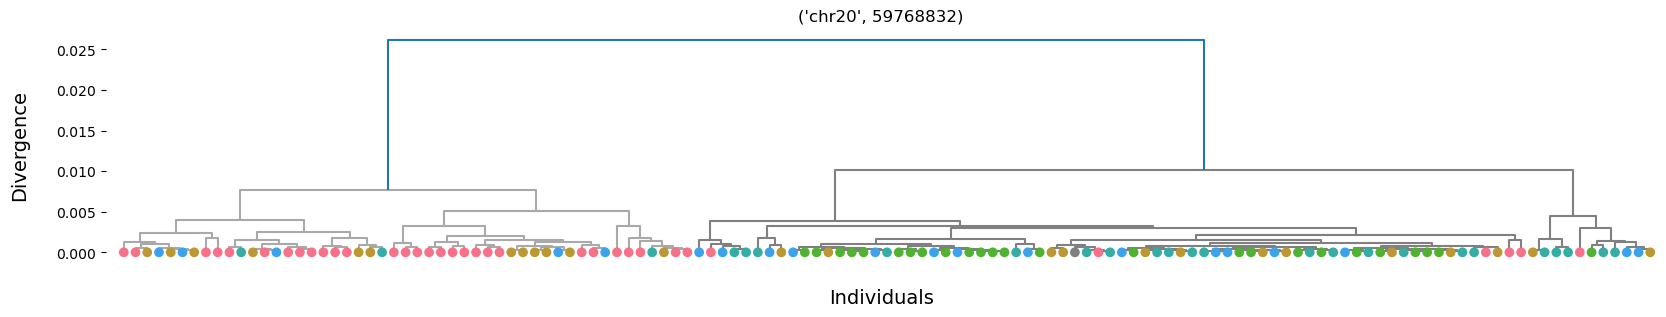

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [35.0, 35.0, 52.5, 52.5],
  [20.0, 20.0, 43.75, 43.75],
  [5.0, 5.0, 31.875, 31.875],
  [75.0, 75.0, 85.0, 85.0],
  [18.4375, 18.4375, 80.0, 80.0],
  [95.0, 95.0, 105.0, 105.0],
  [125.0, 125.0, 135.0, 135.0],
  [115.0, 115.0, 130.0, 130.0],
  [155.0, 155.0, 165.0, 165.0],
  [145.0, 145.0, 160.0, 160.0],
  [122.5, 122.5, 152.5, 152.5],
  [100.0, 100.0, 137.5, 137.5],
  [185.0, 185.0, 195.0, 195.0],
  [175.0, 175.0, 190.0, 190.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [182.5, 182.5, 212.5, 212.5],
  [118.75, 118.75, 197.5, 197.5],
  [49.21875, 49.21875, 158.125, 158.125],
  [245.0, 245.0, 255.0, 255.0],
  [235.0, 235.0, 250.0, 250.0],
  [265.0, 265.0, 275.0, 275.0],
  [285.0, 285.0, 295.0, 295.0],
  [270.0, 270.0, 290.0, 290.0],
  [315.0, 315.0, 325.0, 325.0],
  [305.0, 305.0, 320.0, 320.0],
  [335.0, 335.0, 345.0, 345.0],
  [355.0, 355.0, 365.0, 365.0],
  [375.0, 

In [72]:
get_window_dendrogram(('chr20', 59768832), idx)

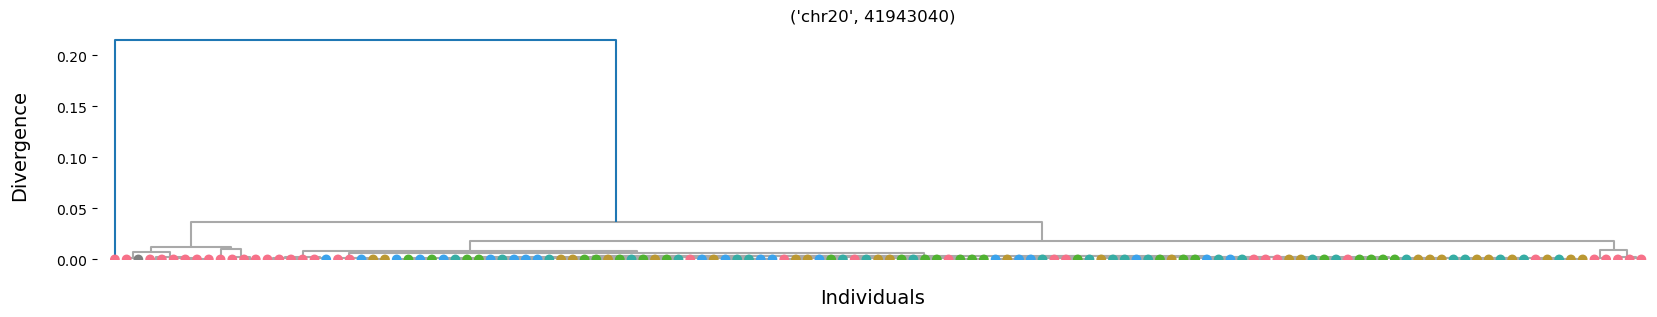

{'icoord': [[15.0, 15.0, 25.0, 25.0],
  [35.0, 35.0, 45.0, 45.0],
  [75.0, 75.0, 85.0, 85.0],
  [65.0, 65.0, 80.0, 80.0],
  [55.0, 55.0, 72.5, 72.5],
  [40.0, 40.0, 63.75, 63.75],
  [20.0, 20.0, 51.875, 51.875],
  [115.0, 115.0, 125.0, 125.0],
  [105.0, 105.0, 120.0, 120.0],
  [95.0, 95.0, 112.5, 112.5],
  [35.9375, 35.9375, 103.75, 103.75],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [150.0, 150.0, 180.0, 180.0],
  [225.0, 225.0, 235.0, 235.0],
  [215.0, 215.0, 230.0, 230.0],
  [205.0, 205.0, 222.5, 222.5],
  [195.0, 195.0, 213.75, 213.75],
  [265.0, 265.0, 275.0, 275.0],
  [255.0, 255.0, 270.0, 270.0],
  [245.0, 245.0, 262.5, 262.5],
  [305.0, 305.0, 315.0, 315.0],
  [295.0, 295.0, 310.0, 310.0],
  [285.0, 285.0, 302.5, 302.5],
  [345.0, 345.0, 355.0, 355.0],
  [335.0, 335.0, 350.0, 350.0],
  [325.0, 325.0, 342.5, 342.5],
  [365.0, 365.0, 375.0, 375.0],
  [333.75, 333.75, 370.0, 370.0],
  [293.75, 2

In [73]:
get_window_dendrogram(('chr20', 41943040), idx)

In [25]:
sum(idw_counts.values())

1272

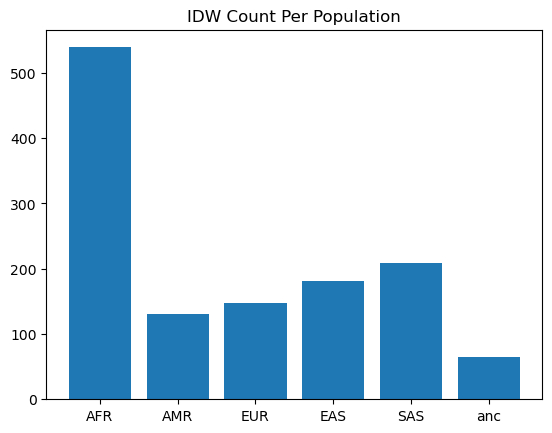

In [26]:
plt.bar(*zip(*idw_counts.items()))
plt.title('IDW Count Per Population')
plt.show()

In [27]:
fdw = counts_df[((counts_df.C0<=5 )& (counts_df.C0>=2 ))|
                ((counts_df.C1<=5 )& (counts_df.C1>=2 ))|
                ((counts_df.C2<=5 )& (counts_df.C2>=2 ))|
                ((counts_df.C3<=5 )& (counts_df.C3>=2 ))|
                ((counts_df.C4<=5 )& (counts_df.C4>=2 ))|
                ((counts_df.C5<=5 )& (counts_df.C5>=2 ))]

In [29]:
def get_smallest_cluster(r, fdw):
    df = fdw.drop(columns=['depth'])
    fdw_row = df.loc[[r]]
    idx = fdw_row.where(fdw_row != 0.0).dropna(axis=1).idxmin(axis=1).values[0]
    size = fdw_row.where(fdw_row != 0.0).dropna(axis=1).min(axis=1).values[0]
    return idx, size

def get_cluster_inds(cluster_id, window):
    inds = dataframe.loc[[window]].where(dataframe.loc[[window]]==cluster_id).dropna(axis=1).columns
    return list(inds)


def get_cluster_purity(df):
    pure_super_list=[]
    supers = []
    pure_sub_list=[]
    subs = []
    cluster_sizes = []
    num_clusters = []
    cs = counts_df[['C0','C1','C2','C3','C4','C5']]
    for row in df.index:
        w = row
        c_n = cs.loc[[w]].where(cs.loc[[w]]!=0.0).dropna(axis=1).shape[1]
        c = get_smallest_cluster(w, df)
        c_id = c[0]
        c_size = int(c[1])
        inds = get_cluster_inds(c_id,w)
        super_pop = inds[0][:3]
        sub_pop = inds[0][4:7]
        pure_super = all(item.startswith(super_pop) for item in inds)
        pure_sub = all(item[4:7]==sub_pop for item in inds)
        pure_super_list.append(pure_super)
        pure_sub_list.append(pure_sub)

        cluster_sizes.append(c_size)
        num_clusters.append(c_n)
        if pure_super:
            supers.append(super_pop)
        else:
            supers.append(np.nan)
        if pure_sub:
            subs.append(sub_pop)
        else:
            subs.append(np.nan)
    df['pure_super'] = pure_super_list
    df['pure_sub'] = pure_sub_list

    df['super'] = supers
    df['sub'] = subs

    df['cluster_size'] = cluster_sizes
    df['num_clusters'] = num_clusters
    return df

    

In [30]:
fdw = get_cluster_purity(fdw)

In [31]:
fdw[fdw.pure_super]

,C0,C1,C2,C3,C4,C5,depth,pure_super,pure_sub,super,sub,cluster_size,num_clusters
"(chr1, 4718592)",0.0,5.0,126.0,0.0,0.0,0.0,0.038550,True,False,AFR,NaN,5,2
"(chr1, 5242880)",0.0,34.0,4.0,93.0,0.0,0.0,0.006143,True,False,AFR,NaN,4,3
"(chr1, 9437184)",0.0,127.0,4.0,0.0,0.0,0.0,0.090592,True,False,EUR,NaN,4,2
"(chr1, 9961472)",0.0,4.0,127.0,0.0,0.0,0.0,0.027768,True,False,EUR,NaN,4,2
"(chr1, 13107200)",0.0,4.0,127.0,0.0,0.0,0.0,0.015496,True,False,AFR,NaN,4,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...
"(chr22, 31457280)",0.0,2.0,129.0,0.0,0.0,0.0,0.014239,True,False,SAS,NaN,2,2
"(chr22, 38797312)",0.0,2.0,129.0,0.0,0.0,0.0,0.004611,True,False,AFR,NaN,2,2
"(chr22, 46137344)",0.0,2.0,129.0,0.0,0.0,0.0,0.011632,True,False,AFR,NaN,2,2
"(chr22, 46661632)",0.0,13.0,3.0,115.0,0.0,0.0,0.029379,True,False,AFR,NaN,3,3


Text(0.5, 1.0, 'Pure Subpop "Few" Driven Windows by Super Pop')

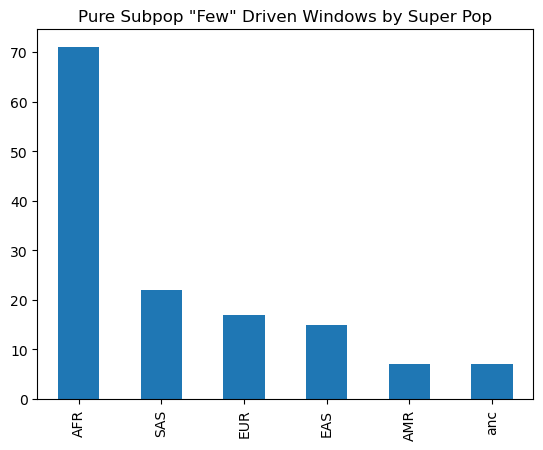

In [32]:
fdw[fdw.pure_sub==True].super.value_counts().plot.bar()
plt.title('Pure Subpop "Few" Driven Windows by Super Pop')

In [33]:
fdw[fdw.pure_sub==True].super.value_counts()

AFR    71
SAS    22
EUR    17
EAS    15
AMR     7
anc     7
Name: super, dtype: int64